# Импортируем библиотеки, данные. Начальный анализ

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [2]:
%pip freeze

absl-py==2.2.1
aiohappyeyeballs==2.6.1
aiohttp==3.11.16
aiosignal==1.3.2
alembic==1.13.2
annotated-types==0.7.0
arch==7.2.0
asttokens==2.4.1
astunparse==1.6.3
attrs==23.2.0
bayesian_changepoint_detection==0.2.dev1
beautifulsoup4==4.12.3
bokeh==3.6.0
Brotli==1.1.0
captum==0.8.0
catboost==1.2.5
category-encoders==2.6.3
certifi==2024.2.2
chardet==5.2.0
charset-normalizer==3.3.2
clarabel==0.9.0
click==8.1.7
cloudpickle==3.0.0
clustergram==0.8.1
cmdstanpy==1.2.5
colorama==0.4.6
colorlog==6.8.2
comet-ml==3.43.2
comm==0.2.2
configobj==5.0.8
contourpy==1.2.1
country-converter==1.2
cvxpy==1.6.0
cycler==0.12.1
Cython==3.0.12
dacite==1.8.1
dash==2.17.1
dash-bootstrap-components==1.3.1
dash-core-components==2.0.0
dash-html-components==2.0.0
dash-table==5.0.0
dash_colorscales==0.0.4
dash_daq==0.5.0
debugpy==1.8.1
decorator==5.1.1
dtale==3.12.0
dulwich==0.22.1
et-xmlfile==1.1.0
everett==3.1.0
executing==2.0.1
fastjsonschema==2.19.1
filelock==3.16.1
Flask==2.2.5
Flask-Compress==1.15
flask-ngrok==0.0.

In [549]:
df = pd.read_csv('data\ghana_gdp.csv', index_col='year', parse_dates=['year'])
df.rename({'GDP (current US$)': 'gdp'}, axis=1, inplace=True)
df

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [550]:
# функция для определения размера полотна, на котором строятся графики
def figsize(x, y):
    plt.rcParams['figure.figsize'] = x, y

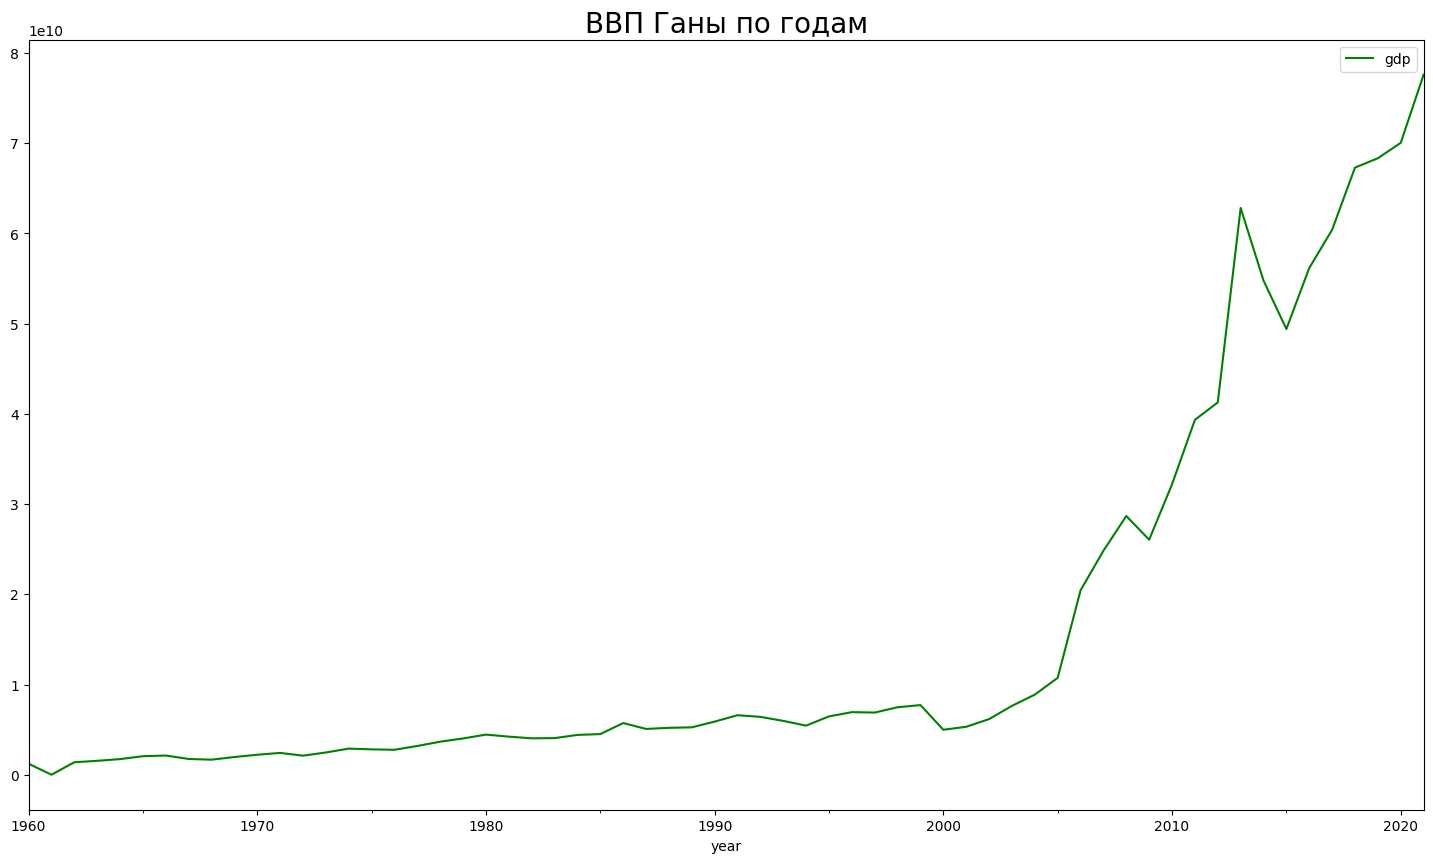

In [551]:
figsize(18, 10)
df.plot(color="green")
plt.title('ВВП Ганы по годам', size=20);

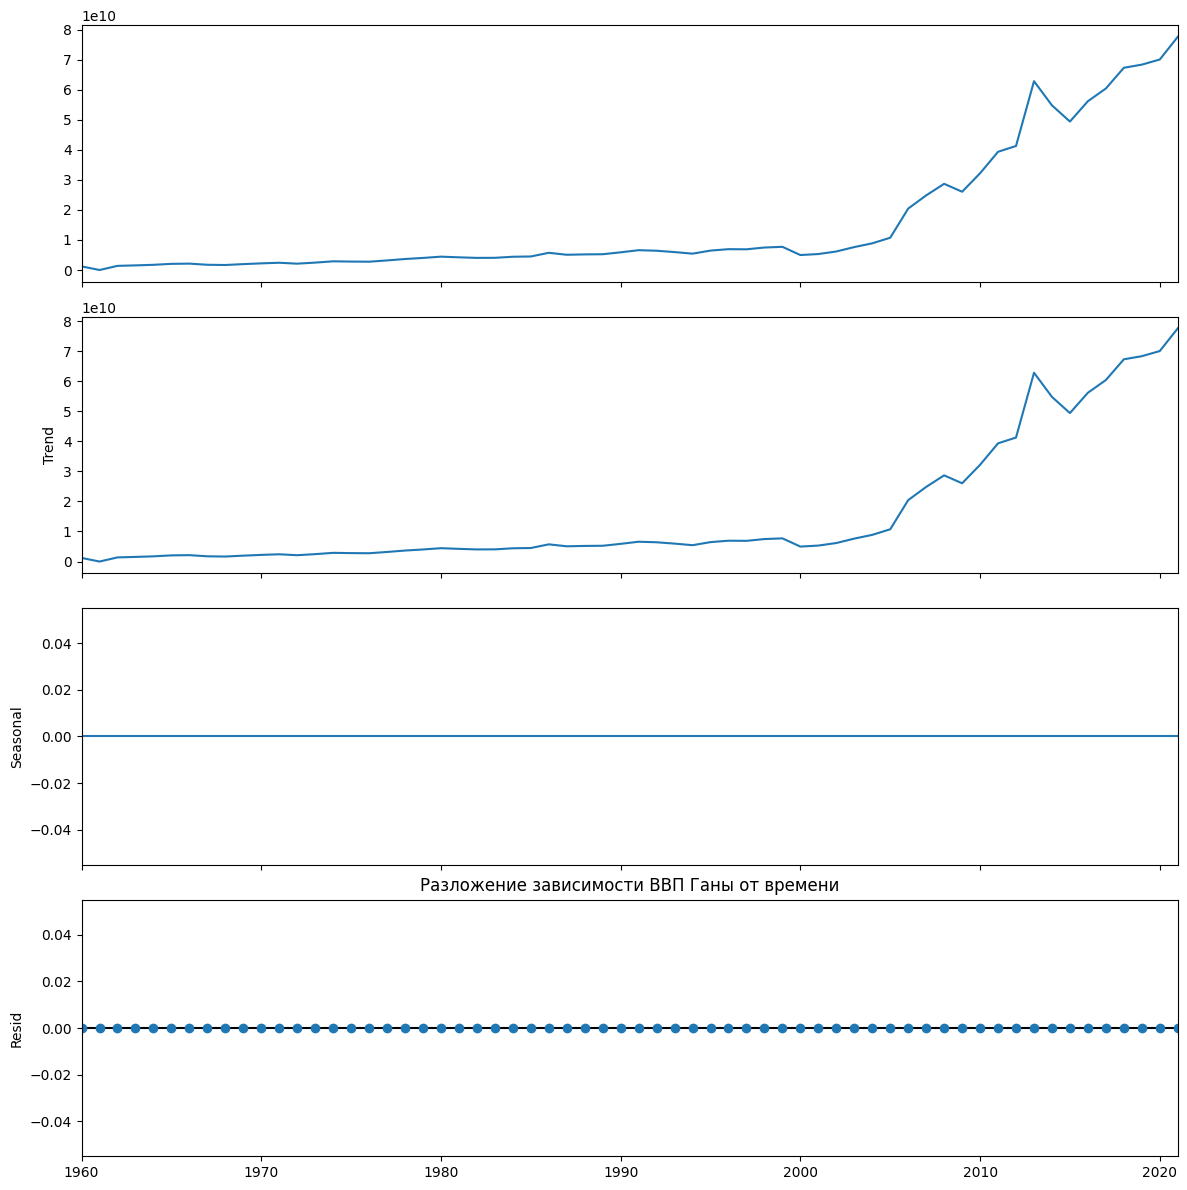

In [552]:
figsize(12, 12)
decompose = seasonal_decompose(df, model="additive")
decompose.plot()
plt.title('Разложение зависимости ВВП Ганы от времени')
plt.show()

<Axes: xlabel='year'>

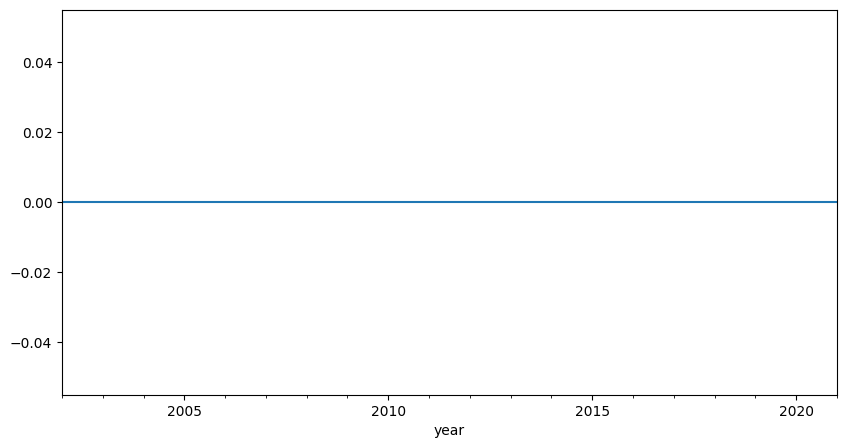

In [553]:
# рассмотрим сезонность в приближении
figsize(10, 5)
decompose.seasonal[-20:].plot()

Из построенных выше графиков можно сделать следующие выводы:
1) В данных отсутствует какая-либо сезонность
2) ВВП страны имеет восходящий тренд
3) Остаточный шум везде приблизительно равен 0, т.е. тренд хорошо улавливает зависимость.

In [554]:
# разделим данные на тренировочную и тестовую выборки
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [555]:
len(df)

62

# MA модель

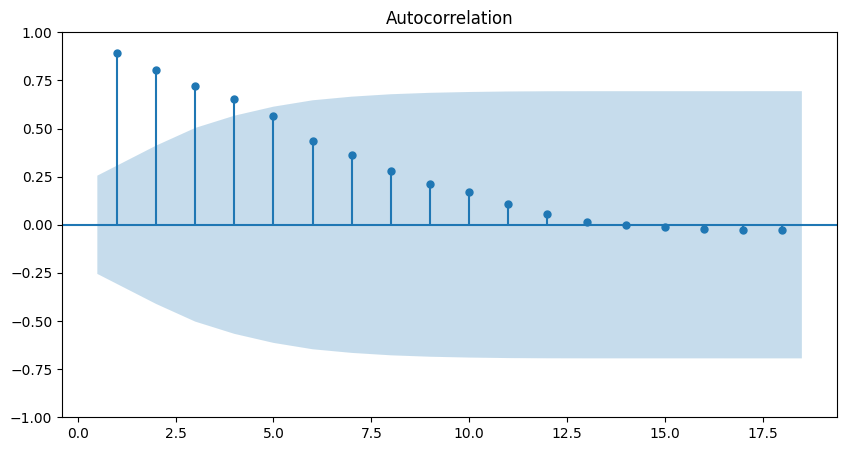

In [556]:
plot_acf(train_df, zero=False)
plt.show()

Судя по графику автокорреляции, оптимальным будет параметр 7-9. Для точности воспользуемся библиотекой pmdarima:

In [557]:
ar_determine_q = pmd.auto_arima(
    train_df, 
    start_q=2, max_q=10, # параметры для q (размер window)
    d=0, D=0, start_p=0, max_p=0, # выставляем степень диффиринциирование и AR равными 0
    error_action='ignore',
    stepwise=False # проходимся по всем значениям
)

ar_determine_q.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(0, 0, 5)   Log Likelihood               -1448.619
Date:                Wed, 16 Apr 2025   AIC                           2911.239
Time:                        00:26:35   BIC                           2925.781
Sample:                    01-01-1960   HQIC                          2916.916
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.281e+10   7.55e-11    1.7e+20      0.000    1.28e+10    1.28e+10
ma.L1          1.2889      0.880      1.465      0.143      -0.435       3.013
ma.L2          1.2774      1.418      0.901      0.368      -1.501       4.056
ma.L3          1.0844      1.373      0.790      0.430      -1.606       3.775
ma.L4          0.5997      1.550      0.387      0.699      -2.439       3.638
ma.L5          0.2759      2.141      0.129      0.897      -3.920       4.472
sigma2      2.957e+20   9.89e-21   2.99e+40      0.000    2.96e+20    2.96e+20
===================================================================================
Ljung-Box (L1) (Q):                   6.13   Jarque-Bera (JB):               168.34
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              16.22   Skew:                             2.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.17e+56. Standard errors may be unstable.
"""

**SARIMAX(0, 0, 5)** - значит, алгоритм выбрал **q = 5**, т.е. так что значение автокорреляции выше 0.5. Возьмем его.

In [558]:
df_ma = df.rolling(window=5).mean().dropna()

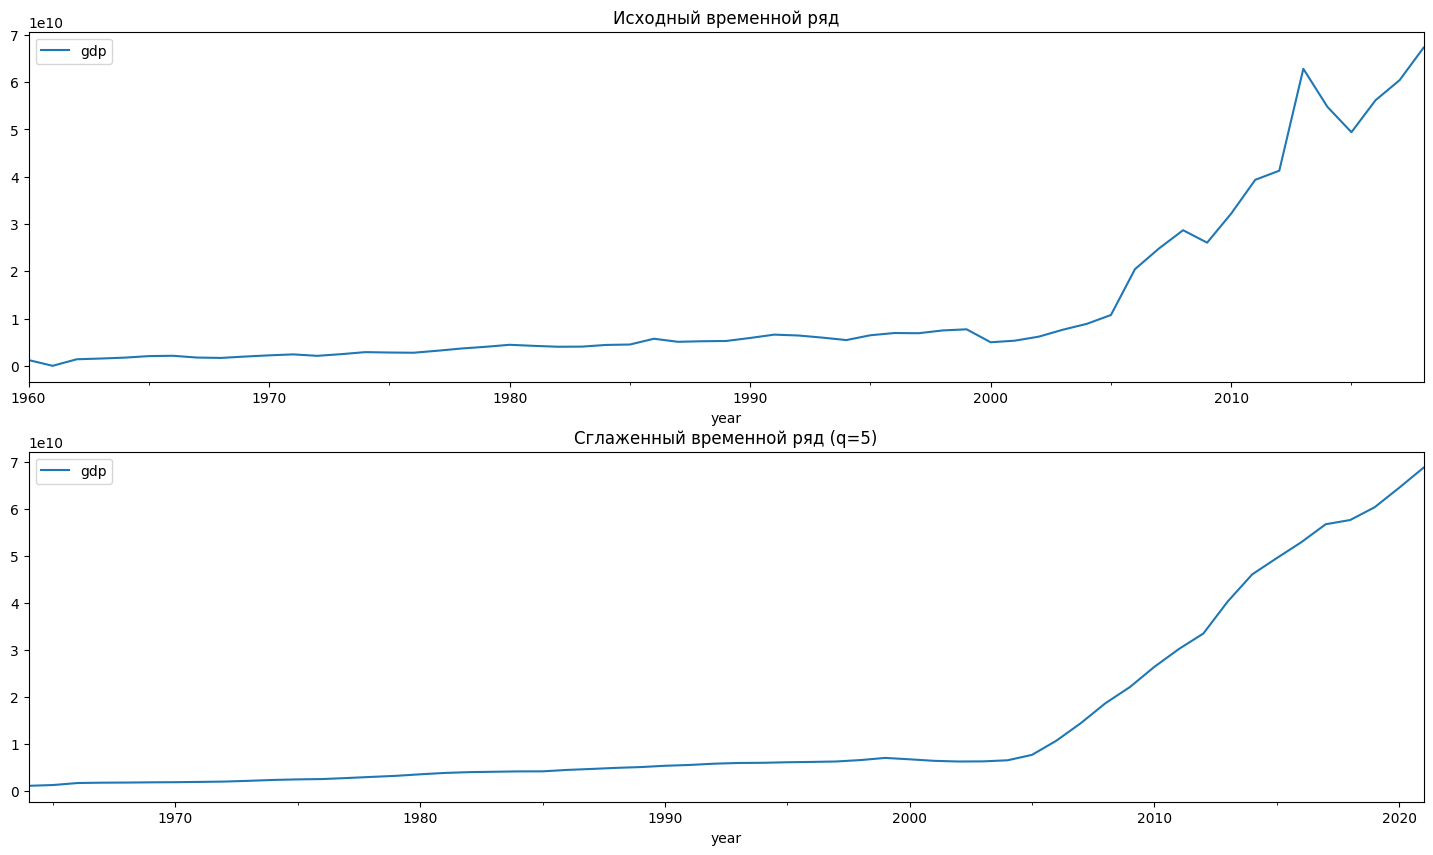

In [559]:
figsize(18, 10)

fig, ax = plt.subplots(2, 1)

train_df.plot(ax=ax[0])
ax[0].set_title("Исходный временной ряд")
df_ma.plot(ax=ax[1])
ax[1].set_title("Сглаженный временной ряд (q=5)");

MA довольно сильно сглаживает значения, убирая, например, резкий рост ВВП в 2013 году.

In [560]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train_df, order=(0, 0, 5)).fit()
pred = arima.predict(start=test_df.index[0], end=test_df.index[-1])
conf_df = arima.get_forecast(len(test_df.index)).conf_int(alpha=0.5)

In [561]:
conf_df

,lower gdp,upper gdp
2019-01-01,4.886530e+10,7.177853e+10
2020-01-01,3.130094e+10,6.876132e+10
2021-01-01,1.140706e+10,5.905434e+10


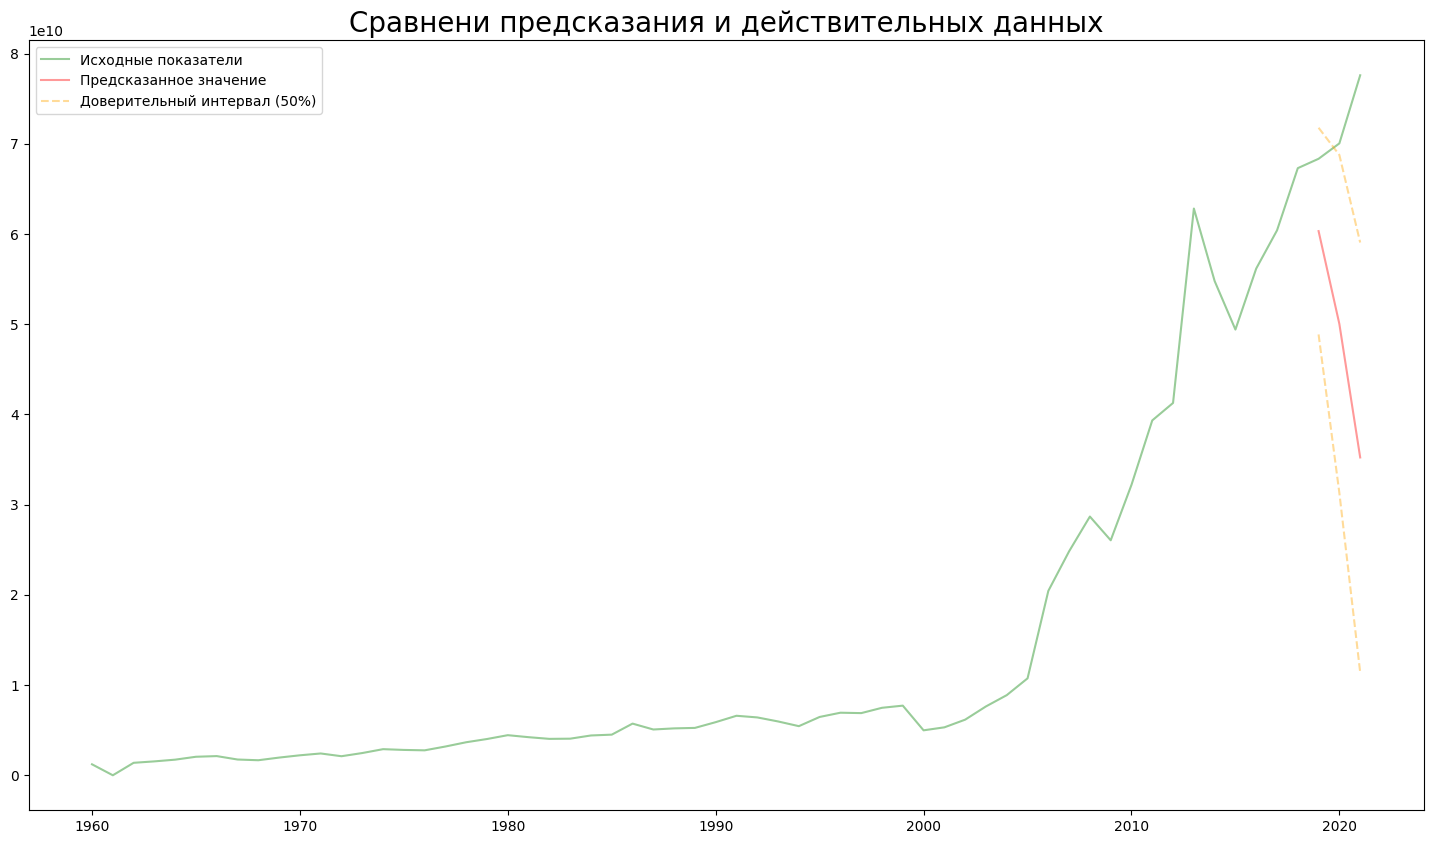

In [562]:
plt.plot(
    df.gdp, color="green",
    label="Исходные показатели",
    alpha=0.4
)

plt.plot(
    pred, 
    color="red", linestyle='-',
    label="Предсказанное значение",
    alpha=0.4
)

plt.plot(
    conf_df.loc[test_df.index]['lower gdp'],
    color="orange",
    linestyle="--",
    label="Доверительный интервал (50%)",
    alpha=0.4
)

plt.plot(
    conf_df['upper gdp'],
    color="orange", linestyle="--",
    alpha=0.4
)

plt.title('Сравнени предсказания и действительных данных', size=20)
plt.legend()

Как видим, значения довольно сильно расходятся с действительностью. 

## Проверка ряда на стационарность. Тест Дики Фуллера

In [563]:
results_adfuller = adfuller(train_df.dropna().gdp)
print('ADF: ', results_adfuller[0])
print('p-value: ', results_adfuller[1])
print('Кол-во лагов: ', results_adfuller[2])
print('Критические значение: ', results_adfuller[4])
if results_adfuller[0] > results_adfuller[4]['5%']:
    print('Есть хотя бы один корень. Ряд нестационарен')
else:
    print('Ряд стационарен')

ADF:  0.6529066974885367
p-value:  0.9888496277665573
Кол-во лагов:  10
Критические значение:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Есть хотя бы один корень. Ряд нестационарен


Исходный ряд нестационарен. Найдем степень дифференциирование ряда до стационарного: 

In [564]:
d = 1
results_adfuller = adfuller(train_df.diff(d).dropna().gdp)

while (results_adfuller[0] > results_adfuller[4]['5%']):
    d += 1
    results_adfuller = adfuller(train_df.diff(d).dropna().gdp)


print('ADF: ', results_adfuller[0])
print('p-value: ', results_adfuller[1])
print('Кол-во лагов: ', results_adfuller[2])
print('Критические значение: ', results_adfuller[4])
print('Ряд стационарен при d =', d)

ADF:  -3.5836708658260292
p-value:  0.006080989753876957
Кол-во лагов:  11
Критические значение:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
Ряд стационарен при d = 2


Отлично, нужно брать дифференциирование второго порядка.

# ARIMA

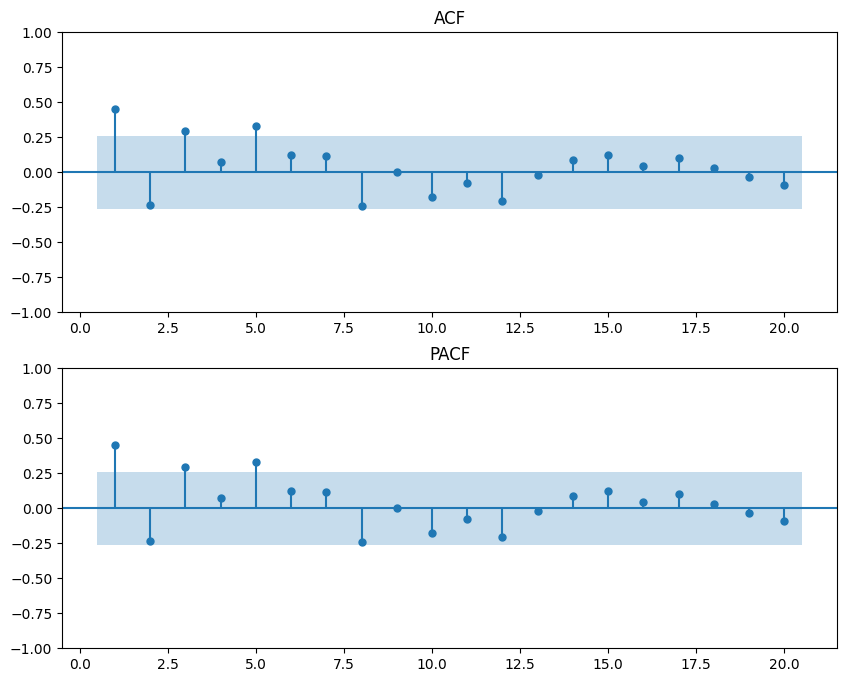

In [565]:
figsize(10, 8)

fig, ax = plt.subplots(2, 1)
plot_pacf(train_df.diff(2).dropna(), lags=20, zero=False, ax=ax[0])
ax[0].set_title('ACF')
plot_pacf(train_df.diff(2).dropna(), lags=20, zero=False, ax=ax[1])
ax[1].set_title('PACF')
plt.show()

По графикам не совсем понятно, какие параметры брать: например, коэффицент около 0.2 (по модулю) можно увидеть вплоть до 12 лага. 
<p>Попробуем отобрать параметры с помощью уже использованного ранее pmdarima:</p>

In [566]:
pmd_determine_p_q = pmd.auto_arima(
    train_df,
    d=2, D=2, # порядок дифференциирования - второй
    start_q=2, max_q = 12, # размер окна
    start_p=2, max_p=12, # порядок AR модели
    stationary=False, seasonal=False, # исходный ряд нестационарен, сезонности нет
    stepwise=True # воспользуемся алгоритмом Хиндмана-Хадакара
)

pmd_determine_p_q.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Wed, 16 Apr 2025   AIC                           2680.765
Time:                        00:26:38   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+55. Standard errors may be unstable.
"""

Алгоритм решил, что оптимальные параметры p=1 и q=3
<p>(если выключить пошаговый перебор, т.е. сделать полный перебор параметров, то наилучшими окажутся p=4, q=1, при них индекс Акаике ниже на 1)</p>

In [567]:
arima_4_2_1 = ARIMA(train_df, order=(4, 2, 1)).fit()
arima_predictions_4_2_1 = arima_4_2_1.predict(start=test_df.index[0], end=test_df.index[-1])
arima_1_2_3 = ARIMA(train_df, order=(1, 2, 3)).fit()
arima_predictions_1_2_3 = arima_1_2_3.predict(start=test_df.index[0], end=test_df.index[-1])

In [568]:
round(rmse(test_df, arima_predictions_1_2_3)) < round(rmse(test_df, arima_predictions_4_2_1))

True

Но как видим, оптимальными все-таки оказались p=1, d=2 и q=3.

In [569]:
# получаем таблицу доверительных интервалов для тестовой выборки
conf_df = arima_1_2_3.get_forecast(len(test_df.index)).conf_int(alpha=0.05)
# сохраним в отдельную таблицу соединение предсказанных значений и доверительных интервалов
pred_df = pd.concat([arima_predictions_1_2_3, conf_df], axis=1)
pred_df.rename({'predicted_mean': 'gdp_pred'}, axis=1, inplace=True)
pred_df

,gdp_pred,lower gdp,upper gdp
2019-01-01,6.789080e+10,5.941329e+10,7.636831e+10
2020-01-01,7.253326e+10,6.050774e+10,8.455877e+10
2021-01-01,7.517348e+10,6.155656e+10,8.879040e+10


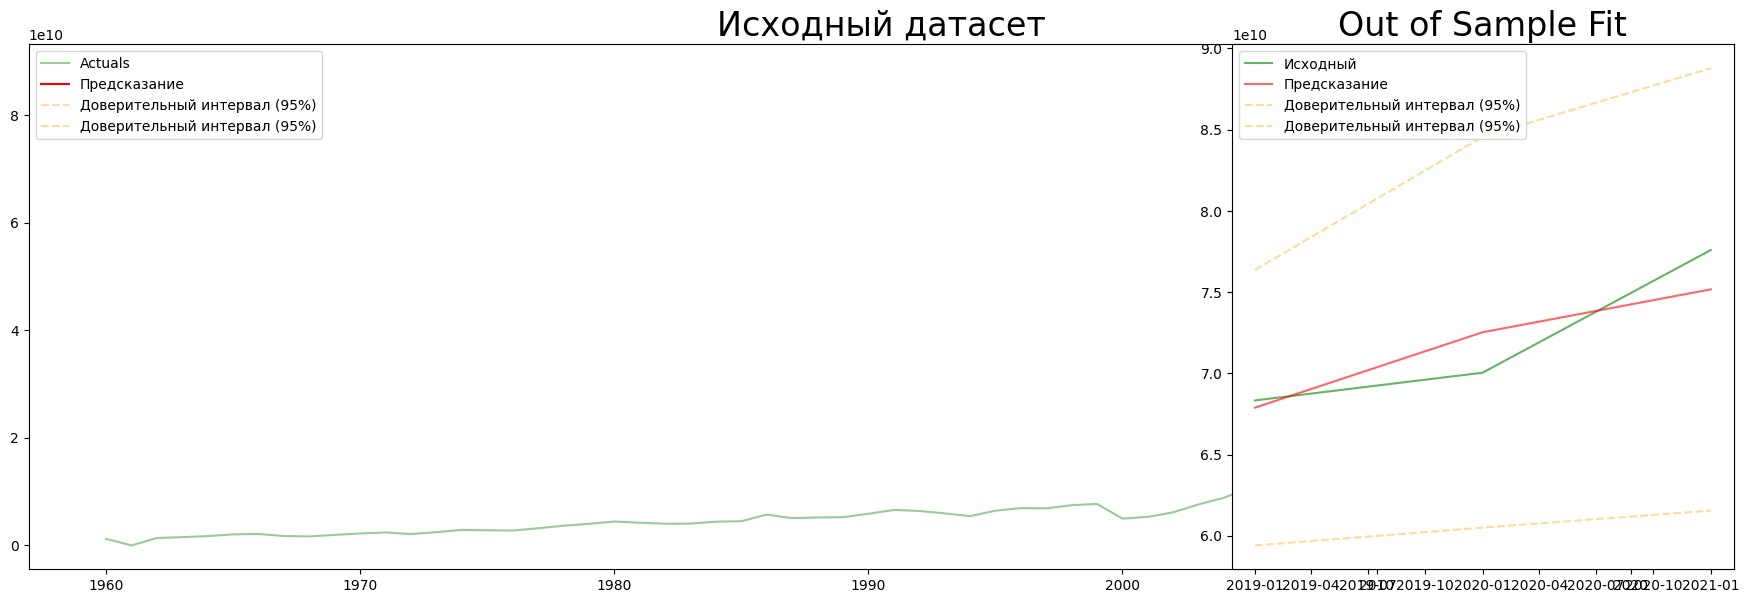

In [570]:
figsize(22, 15)

plt.subplot(2, 1, 1)
# строим все исходные данные
plt.plot(df, color='green', label='Actuals', alpha=0.4)

plt.plot(
    pred_df['gdp_pred'],
    color="red",
    linestyle="-",
    label="Предсказание"
)

plt.plot(
    pred_df['lower gdp'],
    color="orange",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.4
)

plt.plot(
    pred_df['upper gdp'],
    color="orange",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.4
)

plt.title('Исходный датасет', size=24)
plt.legend()

plt.subplot(2, 3, 3)

plt.plot(test_df.gdp, color="green", label="Исходный", alpha=0.6)

plt.plot(
    pred_df.gdp_pred,
    color="red",
    linestyle='-',
    label="Предсказание",
    alpha=0.6
)

plt.plot(
    pred_df['lower gdp'],
    color="orange",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.4
)

plt.plot(
    pred_df['upper gdp'],
    color="orange",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.4
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Итак, как видим, модель довольно точно предсказывает значение. ARIMA придерживается возврастающего тренда, как и исходный датасет. 

---

# Интерполяция

In [571]:
df.asfreq('YS')

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


<Axes: xlabel='year'>

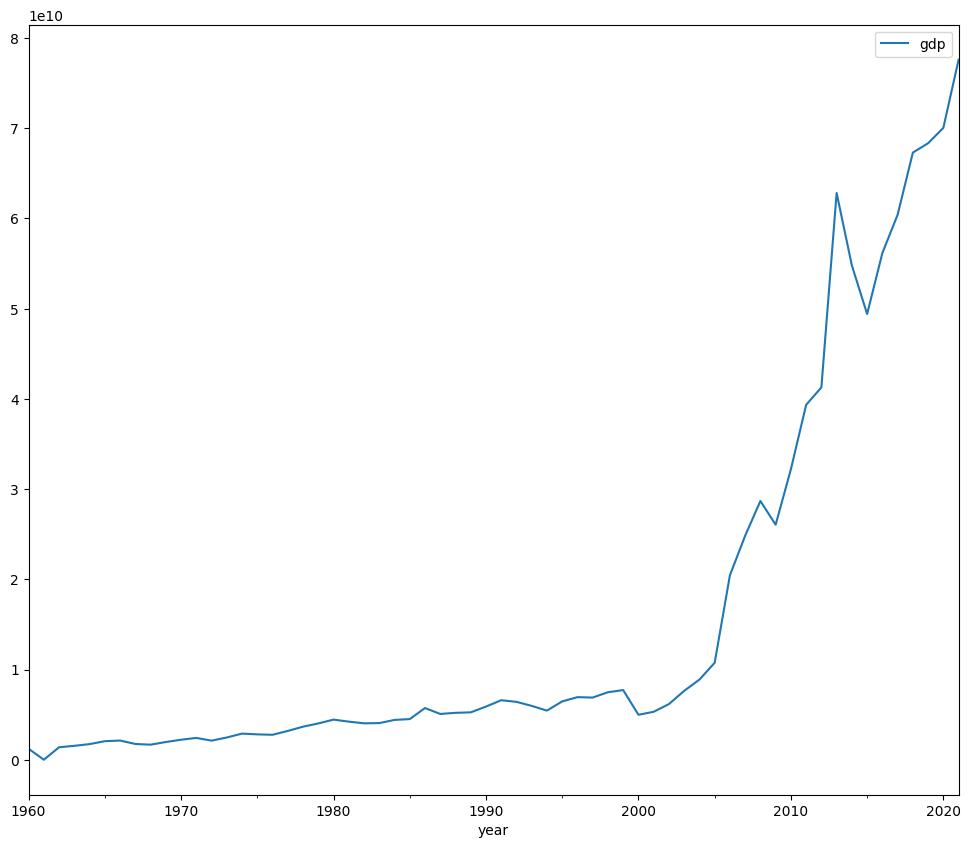

In [572]:
figsize(12, 10)
df.plot()

Уже тут видно странность: в 1961 году зафиксировано ВВП в целых 0 $! Найдем пропуски как Nan и подозрительно маленькие значения

In [573]:
print(df['gdp'].loc[df.isna().gdp])
# условие: ВВП страны меньше миллиона долларов
print(df[df['gdp'] < 1e6])

Series([], Name: gdp, dtype: float64)
            gdp
year           
1961-01-01  0.0


Итак, найдено одно пропущенное значение: 1961 год. Т.к. в 60-х ВВП Ганы было низким и несильно менялось, интерполируем данное значение линейным методом:

In [574]:
df['gdp'] = df['gdp'].apply(lambda x: x if x > 0 else np.nan)
df_inter = pd.DataFrame(df['gdp'].interpolate(method='linear'), index=df.index)

In [575]:
train_df = df_inter.iloc[:-3]
test_df = df_inter.iloc[-3:]

In [576]:
results_inter_aduller = adfuller(train_df)
print('adf: ', results_inter_aduller[0])
print('p-value: ', results_inter_aduller[1])
print('Кол-во лагов: ', results_inter_aduller[2])
print('Критические значения:', results_inter_aduller[4])
if results_inter_aduller[0] > results_inter_aduller[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

adf:  0.8030073326980115
p-value:  0.9916845572455877
Кол-во лагов:  10
Критические значения: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд нестационарен


In [577]:
d = 1
results_adfuller = adfuller(train_df.diff(d).dropna())

while (results_adfuller[0] > results_adfuller[4]['5%']):
    d += 1
    results_adfuller = adfuller(train_df.diff(d).dropna().gdp)


print('ADF: ', results_adfuller[0])
print('p-value: ', results_adfuller[1])
print('Кол-во лагов: ', results_adfuller[2])
print('Критические значение: ', results_adfuller[4])
print('Ряд стационарен при d =', d)

ADF:  -3.99980344094915
p-value:  0.0014115408436661263
Кол-во лагов:  11
Критические значение:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
Ряд стационарен при d = 2


In [578]:
pmd_determine_p_q = pmd.auto_arima(
    train_df,
    d=2, D=2, # порядок дифференциирования - второй
    start_q=2, max_q = 12, # размер окна
    start_p=2, max_p=12, # порядок AR модели
    stationary=False, seasonal=False, # исходный ряд нестационарен, сезонности нет
    stepwise=True # воспользуемся алгоритмом Хиндмана-Хадакара
)

pmd_determine_p_q.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Wed, 16 Apr 2025   AIC                           2680.513
Time:                        00:26:40   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+55. Standard errors may be unstable.
"""

Есои сравнивать с прошлой моделью, то AIC уменьшился лишь на несколько десятых (было 2680.765). Учитывая, что у нас было пропущено только одно значение, это логично. Модель стала немного лучше.

---

# Разбиение данных для временных рядов

In [579]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7) 
test_groups = tscv.split(df_inter)
for train_index, test_index in test_groups:
    print('Размер train: ', len(train_index), '\nРазмер test: ', len(test_index))

Размер train:  41 
Размер test:  7
Размер train:  48 
Размер test:  7
Размер train:  55 
Размер test:  7


---

# Предсказание волатильности. GARCH

In [580]:
# получаем значение волатильности ряда
df_inter['gdp_vol'] = df_inter.pct_change(1).mul(100).abs()
df_inter.head(3)

,gdp,gdp_vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759


In [581]:
train_df = df_inter.iloc[:-3]
test_df = df_inter.iloc[-3:]

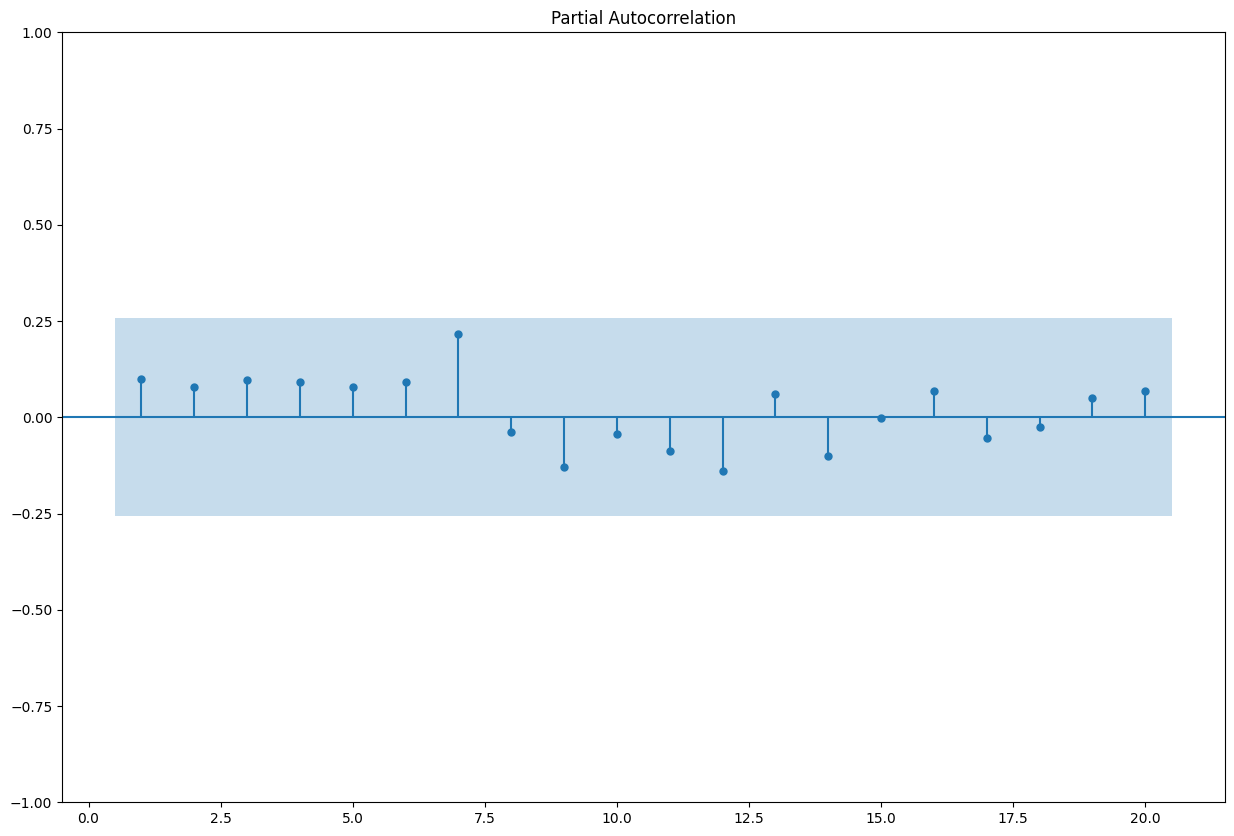

In [582]:
figsize(15, 10)

plot_pacf(train_df.gdp_vol[1:], lags=20, zero=False)
plt.show()

По данному ряду видим, что оптимальнее всего взять параметр p модель GARCH за 7.
<p> Параметр q найдем с помощью графика ACF над остатками модели ARIMA </p>

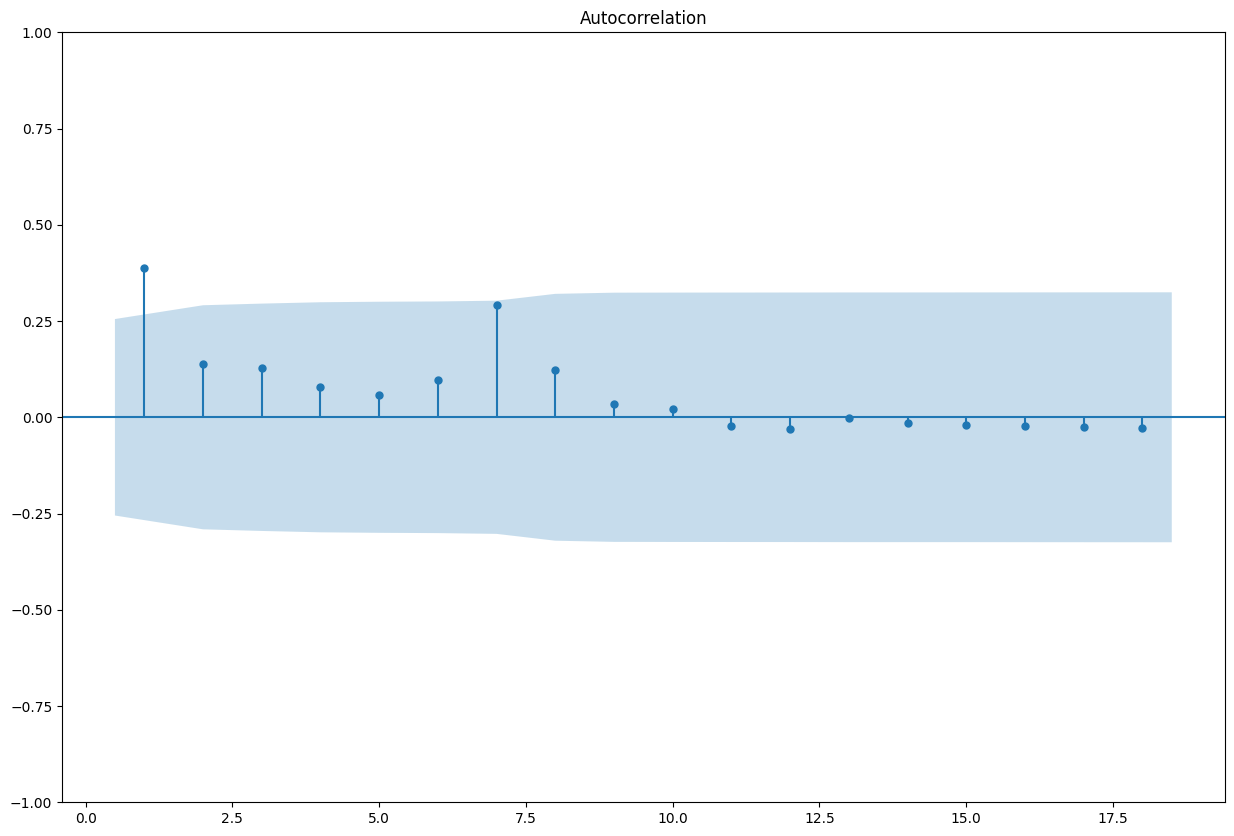

In [583]:
# используем остатки ранее обученной ARIMA(1, 2, 3)
plot_acf(arima_1_2_3.resid**2, zero=False)
plt.show()

q тоже будем брать 7.

In [584]:
adfuller(df_inter['gdp_vol'].dropna())

(-6.80733894469635,
 2.1599127900854784e-09,
 0,
 60,
 {'1%': -3.5443688564814813,
  '5%': -2.9110731481481484,
  '10%': -2.5931902777777776},
 405.49789315481553)

Ряд стационарен, переходим к построению модели.

### GARCH

In [585]:
from arch import arch_model
# подготовка данных
garch_df = pd.DataFrame(df_inter['gdp_vol'].shift(1).loc[df_inter.index])
garch_df.loc[train_df.index, 'gdp_vol'] = train_df['gdp_vol'].dropna()

# обучаем модель
garch = arch_model(garch_df['gdp_vol'].dropna(), p=7, q=7, vol='GARCH')
garch_results = garch.fit(last_obs=test_df.index[0], update_freq=5)
# сводка о модели
garch_results.summary()

Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38048115955718
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759052175603
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.40871495512866
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10079395318482
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.01143994526097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.00780231871062
            Iterations: 29
            Function evaluations: 492
            Gradient evaluations: 28


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.008
Distribution:                  Normal   AIC:                           460.016
Method:            Maximum Likelihood   BIC:                           492.983
                                        No. Observations:                   58
Date:                Wed, Apr 16 2025   Df Residuals:                       57
Time:                        00:26:41   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8666      1.572      7.550  4.349e-14 [  8.786, 14.947]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.1055     42.301      1.043      0.297    [-38.802,1.270e+02]
alpha[1]   3.2351e-08  7.767e-02  4.165e-07      1.000      [ -0.152,  0.152]
alpha[2]   7.8463e-08  2.299e-02  3.412e-06      1.000 [-4.507e-02,4.507e-02]
alpha[3]   6.5621e-14  6.853e-02  9.576e-13      1.000      [ -0.134,  0.134]
alpha[4]   3.6162e-03  1.492e-02      0.242      0.809 [-2.563e-02,3.286e-02]
alpha[5]   6.2496e-14  1.274e-02  4.906e-12      1.000 [-2.497e-02,2.497e-02]
alpha[6]       0.7319      0.915      0.800      0.424      [ -1.062,  2.525]
alpha[7]       0.1024      0.643      0.159      0.873      [ -1.157,  1.362]
beta[1]    5.7084e-07      0.501  1.139e-06      1.000      [ -0.982,  0.982]
beta[2]    3.6496e-07  6.190e-02  5.896e-06      1.000      [ -0.121,  0.121]
beta[3]    3.4349e-07  2.869e-02  1.197e-05      1.000 [-5.624e-02,5.624e-02]
beta[4]    3.0295e-07  9.122e-02  3.321e-06      1.000      [ -0.179,  0.179]
beta[5]    1.7888e-05  5.268e-02  3.396e-04      1.000      [ -0.103,  0.103]
beta[6]    3.6179e-07  3.014e-02  1.200e-05      1.000 [-5.908e-02,5.908e-02]
beta[7]    2.9083e-07      1.155  2.517e-07      1.000      [ -2.265,  2.265]
=============================================================================

Covariance estimator: robust
"""

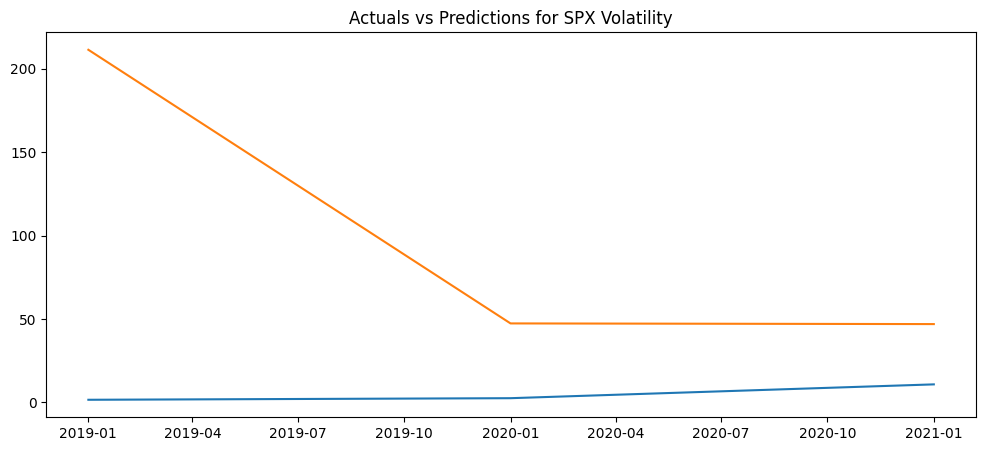

In [586]:
# делаем предсказания
pred_df = test_df.copy()
pred_df['pred'] = garch_results.forecast().residual_variance

# строим графики
figsize(12, 5)
plt.plot(pred_df['gdp_vol'].abs())
plt.plot(pred_df['pred'])

plt.title('Actuals vs Predictions for SPX Volatility')
plt.show()

Как видим, GARCH довольно плохо предсказывает волатильность в начале, затем уже лучше. Возможно, проблема в восходящем тренде в наших данных, а также маленькой тренировочной и тестовой выборке.

---

В коде ниже пытался посмотреть, как будет предсказываться волатильность на самой тренировочной выборке. Тут лучшими параметрами оказались p=1, q=1 (классическая модель), но на тестовой выборке ее предсказание хуже 

In [587]:
# garch = arch_model(garch_df['gdp_vol'].dropna(), p=1, q=2, vol='GARCH')
# garch_results = garch.fit(last_obs=train_df.index[2], update_freq=5)

# pred_df = train_df.copy()
# pred_df['pred'] = garch_results.forecast().residual_variance

# # строим графики
# figsize(12, 5)
# plt.plot(pred_df['gdp_vol'].abs())
# plt.plot(pred_df['pred'], color='green')

# plt.title('Actuals vs Predictions for SPX Volatility')
# plt.show()

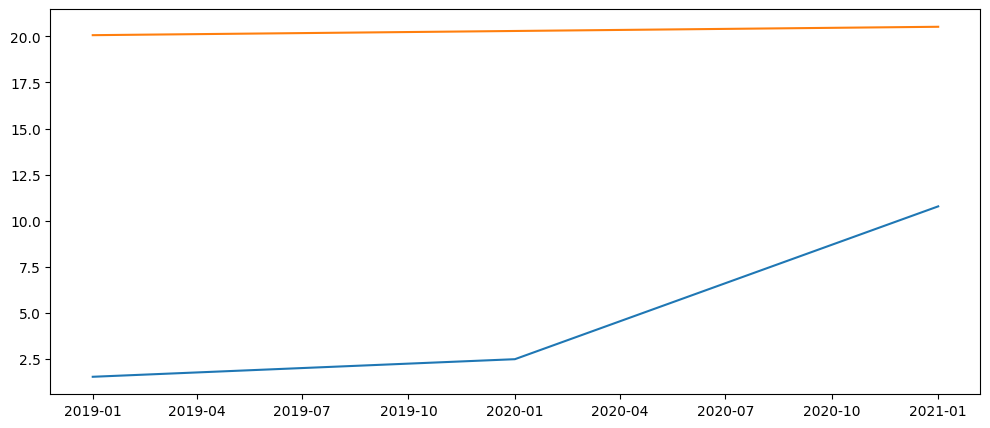

In [588]:
from sklearn.linear_model import LinearRegression
X_train = pd.DataFrame(range(df_inter["gdp_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df_inter["gdp_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["gdp_vol"].fillna(0)
y_test = test_df["gdp_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

---

## Дополнение: продвинутые методы предсказания временных рядов

In [589]:
# подготавливаем данные для моделей типа Prophet
def prepare_for_prophet(df):
    df.drop('gdp_vol', axis=1, inplace=True)
    df['ds'] = df.index
    df.reset_index(drop=True, inplace=True)
    df.rename({'gdp': 'y'}, axis=1, inplace=True)

In [590]:
prepare_for_prophet(train_df)
prepare_for_prophet(test_df)

In [ ]:
# сохраним отмасштабированный тренировочный датасет
train_df_scaled = train_df.copy()
train_df_scaled.y = train_df.y / 1e10

In [591]:
test_df

,y,ds
0,6.833754e+10,2019-01-01
1,7.004320e+10,2020-01-01
2,7.759428e+10,2021-01-01


### Prophet

In [593]:
from prophet import Prophet

prophet = Prophet(growth='linear')
prophet.fit(train_df_scaled)

prophet_pred = prophet.predict(test_df[['ds']])
prophet_pred

00:26:41 - cmdstanpy - INFO - Chain [1] start processing
00:26:41 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,4.826041,2.138500,5.149942,4.826035,4.826046,-1.158370,-1.158370,-1.158370,-1.158370,-1.158370,-1.158370,0.0,0.0,0.0,3.667671
1,2020-01-01,4.906013,2.131133,5.146588,4.905993,4.906032,-1.204987,-1.204987,-1.204987,-1.204987,-1.204987,-1.204987,0.0,0.0,0.0,3.701026
2,2021-01-01,4.986204,2.506131,5.321410,4.986164,4.986247,-1.053958,-1.053958,-1.053958,-1.053958,-1.053958,-1.053958,0.0,0.0,0.0,3.932247


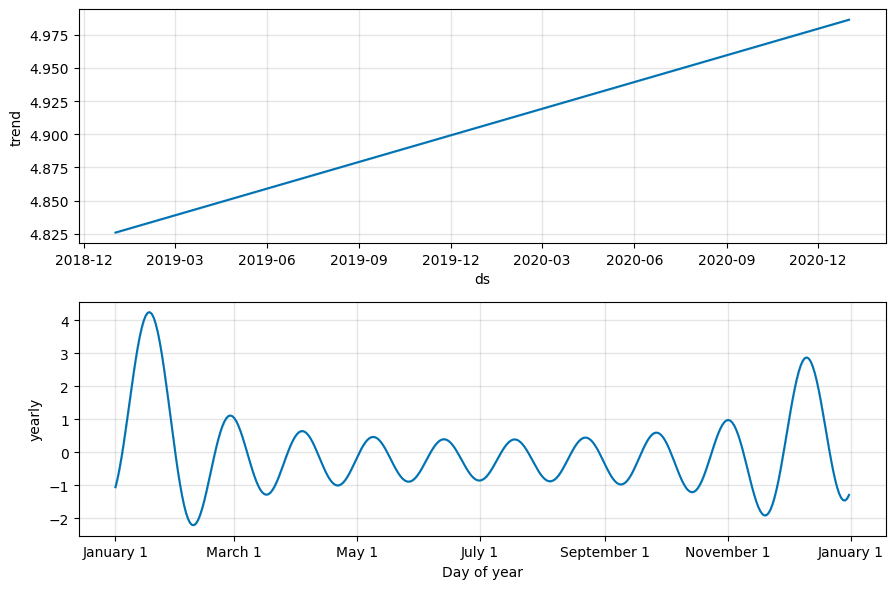

In [594]:
figsize(15, 5)

prophet.plot_components(prophet_pred)
plt.show()

In [595]:
prophet_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,4.826041,2.138500,5.149942,4.826035,4.826046,-1.158370,-1.158370,-1.158370,-1.158370,-1.158370,-1.158370,0.0,0.0,0.0,3.667671
1,2020-01-01,4.906013,2.131133,5.146588,4.905993,4.906032,-1.204987,-1.204987,-1.204987,-1.204987,-1.204987,-1.204987,0.0,0.0,0.0,3.701026
2,2021-01-01,4.986204,2.506131,5.321410,4.986164,4.986247,-1.053958,-1.053958,-1.053958,-1.053958,-1.053958,-1.053958,0.0,0.0,0.0,3.932247


In [596]:
prophet_pred.index = prophet_pred['ds']
prophet_pred.drop('ds', axis=1, inplace=True)

[]

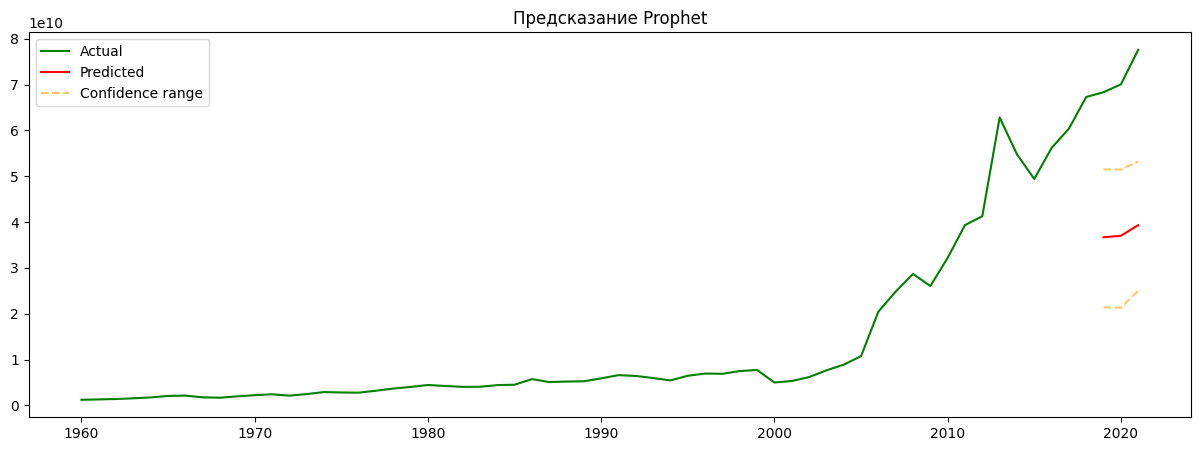

In [597]:
figsize(15, 5)

plt.plot(df_inter.gdp, color='green', label='Actual')
plt.plot(prophet_pred['yhat']*1e10, color='red', label='Predicted')
plt.plot(prophet_pred['yhat_lower']*1e10, color='orange', linestyle='--', alpha=0.6, label='Confidence range')
plt.plot(prophet_pred['yhat_upper']*1e10, color='orange', linestyle='--', alpha=0.6)


plt.legend()
plt.title('Предсказание Prophet')
plt.plot()

Как видим, модель хоть и уловила волатильность, ее предсказание получилось сильно меньше настоящего значения.

---

### NeuralProphet

In [609]:
from neuralprophet import NeuralProphet

neural_prophet = NeuralProphet(
    n_forecasts=3,
    n_lags=1,
    yearly_seasonality=True,
    learning_rate=0.001,
    epochs=200
)
neural_prophet.fit(train_df_scaled, freq='YS')

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 98.305% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8


Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,13.016282,14.892302,1.686622,0.0,0
1,12.979661,14.858811,1.681580,0.0,1
2,12.942489,14.811934,1.676428,0.0,2
3,12.904435,14.775624,1.671127,0.0,3
4,12.865338,14.734221,1.665870,0.0,4
...,...,...,...,...,...
195,0.530006,0.866151,0.036216,0.0,195
196,0.529995,0.866969,0.036213,0.0,196
197,0.529980,0.901609,0.036210,0.0,197
198,0.529963,0.833417,0.036207,0.0,198


In [610]:
future_df = neural_prophet.make_future_dataframe(df=train_df_scaled, periods=3, n_historic_predictions=10)
future_df

INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 98.305% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,y,ds
0,2.867870,2008-01-01
1,2.604811,2009-01-01
2,3.219727,2010-01-01
3,3.933731,2011-01-01
4,4.127095,2012-01-01
5,6.282304,2013-01-01
6,5.478285,2014-01-01
7,4.940657,2015-01-01
8,5.616517,2016-01-01
9,6.040638,2017-01-01


In [611]:
neural_pred = neural_prophet.predict(future_df)
neural_pred

INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS
INFO - (NP.data.processing._handle_missing_data) - Dropped 3 rows at the end with NaNs in 'y' column.


Predicting: 7it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,yhat2,yhat3,ar1,ar2,ar3,trend,season_yearly
0,2008-01-01,2.867870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-01,2.604811,3.268330,NaN,NaN,1.511070,NaN,NaN,-4.110464,5.867724
2,2010-01-01,3.219727,3.370615,1.891460,NaN,1.442543,-0.036611,NaN,-4.039105,5.967176
3,2011-01-01,3.933731,4.296091,2.062723,3.079100,2.198417,-0.034951,0.981427,-3.967745,6.065419
4,2012-01-01,4.127095,5.390612,2.212351,3.202534,3.124997,-0.053264,0.936919,-3.896385,6.162001
5,2013-01-01,6.282304,5.211258,1.967278,3.470844,3.168267,-0.075714,1.427852,-3.824831,5.867822
6,2014-01-01,5.478285,9.429262,2.137128,4.243548,7.215371,-0.076762,2.029657,-3.753471,5.967361
7,2015-01-01,4.940657,7.939206,2.208342,4.440921,5.556046,-0.174818,2.057760,-3.682111,6.065271
8,2016-01-01,5.616517,6.904165,2.416653,7.237587,4.352897,-0.134615,4.686318,-3.610751,6.162020
9,2017-01-01,6.040638,7.545890,2.223328,5.937394,5.217099,-0.105464,3.608601,-3.539196,5.867988


Итак, тут наши предсказания - это последний год в тренировочном датафрейме (2018) и значения yhat1, yhat2 и yhat3 - на 1, 2 и 3 года вперед соответственно. 
<p>Почему в годах, на которые мы делаем предсказания, есть предсказания на будущие года?</p>
<p>Все дело в том, что модель использует autoregressive multi-step forecasting - скользящее предсказание на несколько лагов вперед. Поэтому даже на предсказанных значениях делаются предсказания. Но это псевдопредсказания, которые лучше не рассматривать. </p>

In [612]:
# делаем выборку
y_pred = pd.DataFrame({'y': neural_pred.iloc[10][['yhat1', 'yhat2', 'yhat3']].values*1e10}, index=neural_pred.ds[11:])
y_pred

,y
ds,
2019-01-01,88173074722.290039
2020-01-01,23732876777.648926
2021-01-01,53268575668.334961


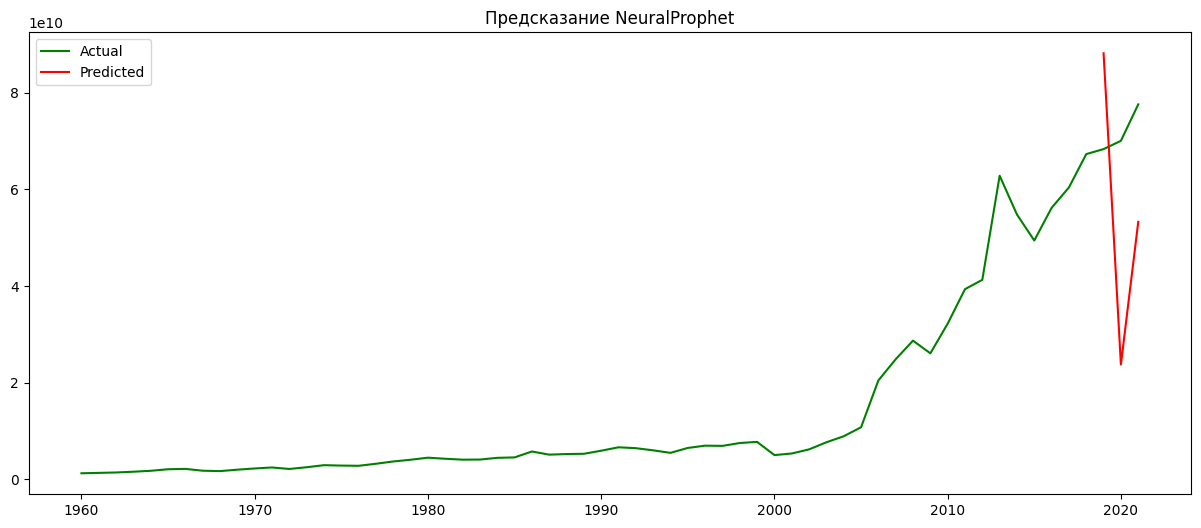

In [613]:
figsize(15, 6)

plt.plot(df_inter.gdp, color='green', label='Actual')
plt.plot(y_pred, color='red', label='Predicted')

plt.legend()
plt.title('Предсказание NeuralProphet')
plt.show()

Получилась довольно непредсказуемая, резвая модель. Сказывается ограниченный размер данных.

# Вывод

Итак, была проделана огромная работа с нашим рядом:

* разложили ряд на составляющие: тренд, сезонность, белый шум;
* провели тест Дики-Фуллера на стационарность ряда;
* изучили данные на наличие пропусков, провели линейную интерполяцию;
* предсказали волатильность благодаря модели GARCH;
* определили оптимальные параметры p, d и q с помощью графиков ACF и PACF, а также библиотеки pmdarima;
* попробовали разные модели для предсказания значений: MA, ARIMA, _Prophet_, _NeuralProphet_;
* визуализировали предсказания и промежуточные итоги.

По результатам проекта можно сказать следующее:


1) Предсказание волатильность с помощью GARCH оказалось не самым точным.
2) Ряд оказался нестационарен, однако дифференциирование второг порядка позволила достичь стационарности;

3) Лучше всех себя показала модель ARIMA(1, 2, 3). Более сложные модели, такие как Prophet и NeuralProphet больше подходят для сложных и более многочисленных данных с сезонностью, сложными зависимостями. Классическая же модель ARIMA показала неплохой результат, как видно по графикам;